In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [3]:
def get_loss(
    activation = 'linear',
    use_bias = 0,
    target_depth = 1,
    frozen_depth = 2,
    init_mode = 'default',
    width = 16,
    exp = 'fnn',
    pretrained = 0,
    tune_bias = 1,
):
    test_loss = {}
    if pretrained:
        pretrained_idx = df.pretrained == 1
    else:
        # since there are many results with pretrained = NaN
        # they were run before I implemented the pretrained feature in my code
        pretrained_idx = df.pretrained != 1
        
    if tune_bias == 0:
        tune_bias_idx = df.tune_bias == 0
    else:
        # since there are many results with tune_bias = NaN
        # they were run before I implemented the tune_bies feature in my code
        tune_bias_idx = df.tune_bias != 0
        
        
    for method in ['sgd', 'ours']:
        run_idx = (
            (df.activation == activation) & 
            (df.method == method) & 
            (df.use_bias == use_bias) & 
            (df.target_depth == target_depth) & 
            (df.frozen_depth == frozen_depth) & 
            (df.init_mode == init_mode) & 
            (df.width == width) &
            (df.exp == exp) &
            pretrained_idx &
            tune_bias_idx
        )

        group_df = df[run_idx].reset_index(drop = True)
        rank_set = np.unique(group_df['rank'])
        group_df_rank = {}
        test_loss[method] = {}
        for rank in rank_set:
            group_df_rank[rank] = group_df[group_df['rank'] == rank]
            if method == 'sgd':
                min_loss_index = group_df_rank[rank]['val_loss'].idxmin()
                row_with_min_loss = group_df_rank[rank].loc[min_loss_index]
                test_loss[method][rank] = row_with_min_loss['test_loss']
            elif method == 'ours':
                test_loss[method][rank] = group_df_rank[rank]['test_loss'].iloc[0]
            else:
                raise notImplementError(f"We only support sgd and ours, not {method}!")
                
    return {
        'test_loss': pd.DataFrame(test_loss), 
        'sv': group_df['singular_values'],
    }

In [4]:
def proceed_singular_values(singular_values):
    # Remove rows with NaN values
    singular_values = singular_values.dropna()

    # Initialize a list to collect all coordinates from all rows
    sv_matrix = []

    # Split each row into its respective coordinate list
    for i, row in enumerate(singular_values):
        sv_matrix.append([])
        sum_all = sum(np.array(row)**2)
        sum_front = 0
        for val in row:
            sum_front += val**2
            sv_matrix[i].append(sum_all - sum_front)

    sv_matrix = np.array(sv_matrix)

    # Calculate mean and standard deviation for each column
    mean_values = np.mean(sv_matrix, axis=0)
    std_values = np.std(sv_matrix, axis=0)
    return mean_values, std_values

In [5]:
def proceed_singular_values(singular_values):
    # Remove rows with NaN values
    singular_values = singular_values.dropna()

    # Initialize a list to collect all coordinates from all rows
    sv_matrix = []

    # Split each row into its respective coordinate list
    for i, row in enumerate(singular_values):
        sv_matrix.append(row)

    sv_matrix = np.array(sv_matrix)

    # Calculate mean and standard deviation for each column
    mean_values = np.mean(sv_matrix, axis=0)
    std_values = np.std(sv_matrix, axis=0)
    return mean_values, std_values

# Randomly Initialized

## Linear Model Approximation

In [6]:
activation = 'linear'
use_bias = 0
target_depth = 1
frozen_depth = 2
width = 16
exp = 'fnn'
pretrained = 0

In [7]:
default_ma_results = get_loss(
    activation = activation,
    use_bias = use_bias,
    target_depth = target_depth,
    frozen_depth = frozen_depth,
    init_mode = 'default',
    width = width,
    exp = exp,
    pretrained = pretrained,
)

uniform_ma_results = get_loss(
    activation = activation,
    use_bias = use_bias,
    target_depth = target_depth,
    frozen_depth = frozen_depth,
    init_mode = 'uniform_singular_values',
    width = width,
    exp = exp,
    pretrained = pretrained,
)

default_ma_loss, (default_mean_sv, default_std_sv) = default_ma_results['test_loss'], proceed_singular_values(default_ma_results['sv'])
uniform_ma_loss, (uniform_mean_sv, uniform_std_sv) = uniform_ma_results['test_loss'], proceed_singular_values(uniform_ma_results['sv'])

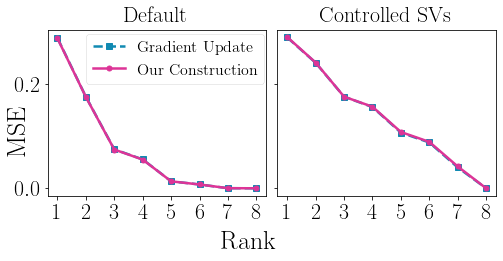

In [8]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = np.arange(8)+1
sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.1, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

# Default Initialization (Xavier Initialization)
default_ma_loss['sgd'].loc[rank_list].plot(ax = ax[0], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
default_ma_loss['ours'].loc[rank_list].plot(ax = ax[0], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
ax[0].set_xticks(rank_list)

# Uniform Singular Values Initialization
uniform_ma_loss['sgd'].loc[rank_list].plot(ax = ax[1], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker, linewidth = lw, markersize = sgd_ms)
uniform_ma_loss['ours'].loc[rank_list].plot(ax = ax[1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker, linewidth = lw, markersize = our_ms)
ax[1].set_xticks(rank_list)

ax[0].legend(fontsize=16, bbox_to_anchor=(0.14,1.02))
fig.supylabel('MSE', fontsize = 26)
fig.supxlabel('Rank', fontsize = 26)

ax[0].set_title('Default', size = 22, y = 1.01)
ax[1].set_title('Controlled SVs', size = 22, y = 1.01)
# ax[0].set_xticks([4,8,12,16])
# ax[1].set_xticks([4,8,12,16])

plt.savefig('../figures/matrix_approx_1.pdf')
# Show the plot
plt.show()


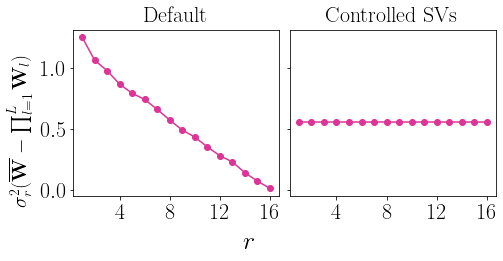

In [9]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.15, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

# Plot mean line
ax[0].plot(np.arange(width)+1, default_mean_sv, label='Mean', marker='o', color = our_color)
# Plot shaded area for standard deviation
# ax[1][0].fill_between(np.arange(width)+1, default_mean_sv - default_std_sv, default_mean_sv + default_std_sv, alpha=0.2, label='Std Dev', color = our_color)


# Plot mean line
ax[1].plot(np.arange(width)+1, uniform_mean_sv, label='Mean', marker='o', color = our_color)

# ax[0].legend(fontsize=16, bbox_to_anchor=(0.14,1.02))
fig.supylabel(r'$\sigma_r^2 (\overline{\mathbf{W}} - \prod_{l=1}^L \mathbf{W}_l)$', fontsize = 20)
fig.supxlabel(r'$r$', fontsize = 26)

ax[0].set_title('Default', size = 22, y = 1.01)
ax[1].set_title('Controlled SVs', size = 22, y = 1.01)
ax[0].set_xticks([4,8,12,16])
ax[1].set_xticks([4,8,12,16])

plt.savefig('../figures/matrix_approx_2.pdf')
# Show the plot
plt.show()


/tmp/ipykernel_1554912/3407948612.py:13: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
/tmp/ipykernel_1554912/3407948612.py:15: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])


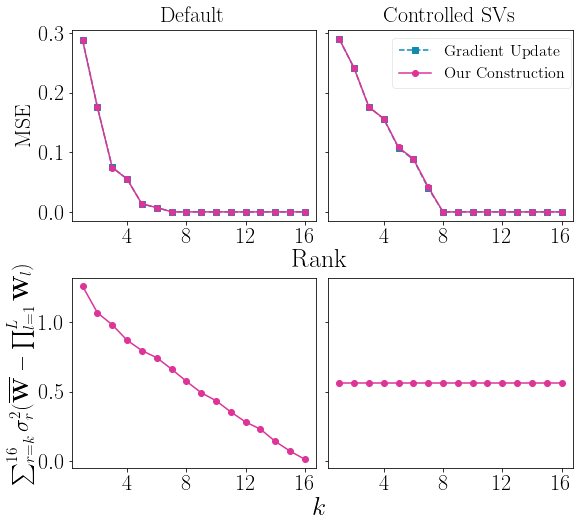

In [10]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(left=0.12, bottom=.18, right=0.99, top=0.94, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(8, 8) #exact size of the figure
# First row share the same y-axis
ax[0, 0].get_shared_y_axes().join(ax[0, 0], ax[0, 1])
# Second row share the same y-axis
ax[1, 0].get_shared_y_axes().join(ax[1, 0], ax[1, 1])

# Default Initialization (Xavier Initialization)
default_ma_loss['sgd'].plot(ax = ax[0][0], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker)
default_ma_loss['ours'].plot(ax = ax[0][0], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker)
ax[0][0].set_xticks(rank_list)

# Uniform Singular Values Initialization
uniform_ma_loss['sgd'].plot(ax = ax[0][1], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker)
uniform_ma_loss['ours'].plot(ax = ax[0][1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker)
ax[0][1].set_xticks(rank_list)

ax[0][1].legend(fontsize=16, bbox_to_anchor=(0.23,1))

# fig.supylabel('MSE', fontsize = 26)

ax[0][0].set_title('Default', size = 22, y = 1.01)
ax[0][1].set_title('Controlled SVs', size = 22, y = 1.01)

# Plot mean line
ax[1][0].plot(np.arange(width)+1, default_mean_sv, label='Mean', marker='o', color = our_color)
# Plot shaded area for standard deviation
# ax[1][0].fill_between(np.arange(width)+1, default_mean_sv - default_std_sv, default_mean_sv + default_std_sv, alpha=0.2, label='Std Dev', color = our_color)


# Plot mean line
ax[1][1].plot(np.arange(width)+1, uniform_mean_sv, label='Mean', marker='o', color = our_color)
# Plot shaded area for standard deviation
# ax[1][1].fill_between(np.arange(width)+1, uniform_mean_sv - uniform_std_sv, uniform_mean_sv + uniform_std_sv, alpha=0.2, label='Std Dev', color = our_color)
# ax[1][1].legend(fontsize=16, bbox_to_anchor=(0.48,0.65))

# set the x-ticks
ax[1, 0].set_xticks([4, 8, 12, 16])
ax[1, 1].set_xticks([4, 8, 12, 16])
ax[0, 0].set_xticks([4, 8, 12, 16])
ax[0, 1].set_xticks([4, 8, 12, 16])


# Set y-labels for each row
ax[0, 0].set_ylabel('MSE', fontsize = 22)
ax[1, 0].set_ylabel(r'$\sum_{r=k}^{16} \sigma_r^2 (\overline{\mathbf{W}} - \prod_{l=1}^L \mathbf{W}_l)$', fontsize = 22)

# Add common x-labels for each row
fig.text(0.55, 0.54, 'Rank', ha='center', va='center', fontsize=26)
fig.text(0.55, 0.11, r'$k$', ha='center', va='center', fontsize=26)

plt.savefig('../figures/matrix_approx.pdf')
# Show the plot
plt.show()


## FNN Approximation

In [11]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
target_depths = [1,2]
pretrained = 0

fnn_results = {}
for target_depth in target_depths:
    fnn_results[target_depth] = get_loss(
        activation = activation,
        use_bias = use_bias,
        target_depth = target_depth,
        frozen_depth = frozen_depth * target_depth,
        init_mode = init_mode,
        width = width,
        exp = exp,
        pretrained = pretrained,
    )['test_loss']

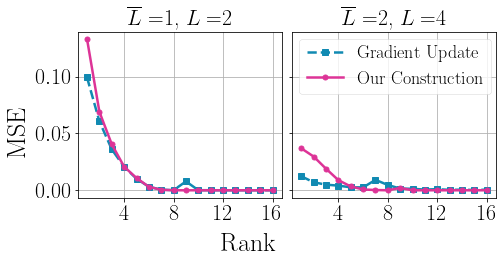

In [12]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, linewidth = lw, markersize = sgd_ms)
    fnn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, linewidth = lw, markersize = our_ms)
    ax[i].set_xticks(rank_list) 
    ax[i].set_title(r'$\overline{L} =$' + str(target_depth) + r', $L =$' + str(target_depth * 2), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=18, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/fnn_approx.pdf')
# Show the plot
plt.show()


## TFN Approximation

In [13]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'tfn'
pretrained = 0

target_depths = [1,2]

tfn_results = {}
for target_depth in target_depths:
    tfn_results[target_depth] = get_loss(
        activation = activation,
        use_bias = use_bias,
        target_depth = target_depth,
        frozen_depth = target_depth,
        init_mode = 'default',
        width = width,
        exp = exp,
        pretrained = pretrained,
    )['test_loss']

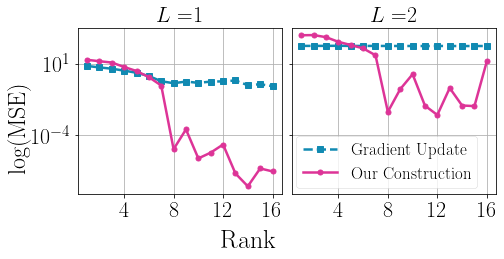

In [14]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = True, linewidth = lw, markersize = sgd_ms)
    tfn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = True, linewidth = lw, markersize = our_ms)
    ax[i].set_xticks(rank_list)
    ax[i].set_title(r'$L=$'+str(target_depth), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)


# ax[0].set_ylim(0,0.15)
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('log(MSE)', fontsize = 24)
ax[1].legend(fontsize=17, bbox_to_anchor=(0.95,0.4))
    
plt.savefig('../figures/tfn_approx.pdf')
# Show the plot
plt.show()


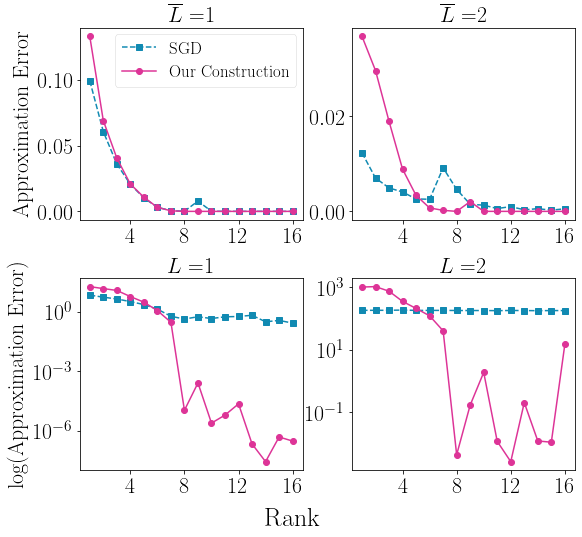

In [15]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(left=0.13, bottom=.12, right=0.99, top=0.94, wspace=0.22, hspace = 0.3) #margin of the figure
fig.set_size_inches(8, 7.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[0][i], label = 'SGD', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt)
    fnn_results[target_depth]['ours'].plot(ax = ax[0][i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt)
    ax[0][i].set_xticks(rank_list) 
    ax[0][i].set_title(r'$\overline{L} =$' + str(target_depth), fontsize = 22)
    
for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[1][i], label = 'SGD', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = True)
    tfn_results[target_depth]['ours'].plot(ax = ax[1][i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = True)
    ax[0][i].set_xticks([4,8,12,16])
    ax[1][i].set_xticks([4,8,12,16])
    ax[1][i].set_title(r'$L=$'+str(target_depth), fontsize = 22)

# ax[0].set_ylim(0,0.15)
ax[0][0].legend(fontsize=17, bbox_to_anchor=(0.12,1.01))
fig.supxlabel('Rank', fontsize = 26)
# fig.supylabel('Approximation Error', fontsize = 26)
# Set y-labels for each row
ax[0, 0].set_ylabel('Approximation Error', fontsize = 22)
ax[1, 0].set_ylabel('log(Approximation Error)', fontsize = 22)
    
plt.savefig('../figures/fnn_tfn_approx.pdf')
# Show the plot
plt.show()


# Pretrained Models

In [16]:
activation = 'linear'
use_bias = 0
target_depth = 1
frozen_depth = 2
width = 16
exp = 'fnn'
pretrained = 1

In [17]:
default_ma_results = get_loss(
    activation = activation,
    use_bias = use_bias,
    target_depth = target_depth,
    frozen_depth = frozen_depth,
    init_mode = 'default',
    width = width,
    exp = exp,
    pretrained = pretrained,
)

uniform_ma_results = get_loss(
    activation = activation,
    use_bias = use_bias,
    target_depth = target_depth,
    frozen_depth = frozen_depth,
    init_mode = 'uniform_singular_values',
    width = width,
    exp = exp,
    pretrained = pretrained,
)

default_ma_loss, (default_mean_sv, default_std_sv) = default_ma_results['test_loss'], proceed_singular_values(default_ma_results['sv'])
uniform_ma_loss, (uniform_mean_sv, uniform_std_sv) = uniform_ma_results['test_loss'], proceed_singular_values(uniform_ma_results['sv'])

/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/skunk-pod-storage-yzeng58-40wisc-2eedu-pvc/anaconda3/envs/ibm/lib/python3.8/site-packages/numpy/core

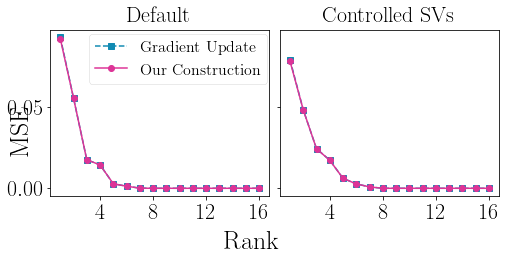

In [18]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.1, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

# Default Initialization (Xavier Initialization)
default_ma_loss['sgd'].plot(ax = ax[0], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker)
default_ma_loss['ours'].plot(ax = ax[0], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker)
ax[0].set_xticks(rank_list)

# Uniform Singular Values Initialization
uniform_ma_loss['sgd'].plot(ax = ax[1], color = sgd_color, label = 'Gradient Update', linestyle = sgd_lt, marker = sgd_marker)
uniform_ma_loss['ours'].plot(ax = ax[1], color = our_color, label = 'Our Construction', linestyle = our_lt, marker = our_marker)
ax[1].set_xticks(rank_list)

ax[0].legend(fontsize=16, bbox_to_anchor=(0.14,1.02))
fig.supylabel('MSE', fontsize = 26)
fig.supxlabel('Rank', fontsize = 26)

ax[0].set_title('Default', size = 22, y = 1.01)
ax[1].set_title('Controlled SVs', size = 22, y = 1.01)
ax[0].set_xticks([4,8,12,16])
ax[1].set_xticks([4,8,12,16])

plt.savefig('../figures/matrix_approx_1_pretrained.pdf')
# Show the plot
plt.show()

## FNN Approximation

In [19]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
target_depths = [1,2]
pretrained = 1

fnn_results = {}
for target_depth in target_depths:
    fnn_results[target_depth] = get_loss(
        activation = activation,
        use_bias = use_bias,
        target_depth = target_depth,
        frozen_depth = frozen_depth * target_depth,
        init_mode = init_mode,
        width = width,
        exp = exp,
        pretrained = pretrained,
    )['test_loss']

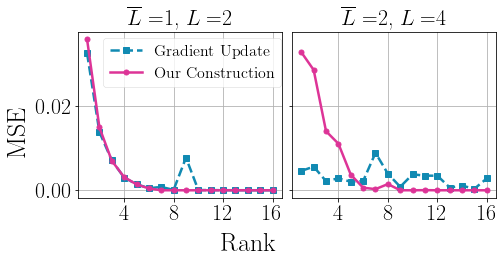

In [20]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, linewidth = lw, markersize = sgd_ms)
    fnn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, linewidth = lw, markersize = our_ms)
    ax[i].set_xticks(rank_list) 
    ax[i].set_title(r'$\overline{L} =$' + str(target_depth) + r', $L =$' + str(target_depth * 2), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)

# ax[0].set_ylim(0,0.15)
ax[0].legend(fontsize=16, bbox_to_anchor=(0.085,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/fnn_approx_pretrained.pdf')
# Show the plot
plt.show()


## TFN Approximation

In [21]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'tfn'
pretrained = 1

target_depths = [1,2]

tfn_results = {}
for target_depth in target_depths:
    tfn_results[target_depth] = get_loss(
        activation = activation,
        use_bias = use_bias,
        target_depth = target_depth,
        frozen_depth = target_depth,
        init_mode = 'default',
        width = width,
        exp = exp,
        pretrained = pretrained,
    )['test_loss']

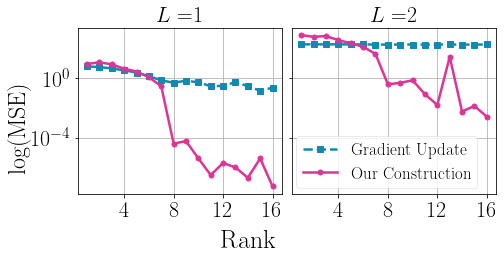

In [22]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_list = pd.Series(default_ma_loss['ours']).index.tolist()

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = True, linewidth = lw, markersize = sgd_ms)
    tfn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = True, linewidth = lw, markersize = our_ms)
    ax[i].set_xticks(rank_list)
    ax[i].set_title(r'$L=$'+str(target_depth), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)


# ax[0].set_ylim(0,0.15)
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('log(MSE)', fontsize = 24)
ax[1].legend(fontsize=17, bbox_to_anchor=(0.95,0.4))
    
plt.savefig('../figures/tfn_approx_pretrained.pdf')
# Show the plot
plt.show()
